# Classifiers Gravitational Wave Demo

## Setup

In [129]:
import os
import sys
import copy
import json
import pathlib
import numpy as np
import pandas as pd
import scipy
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform

# ensure project root (with 'config/' and 'src/') is on sys.path
project_root = pathlib.Path.cwd().resolve()
if not (project_root / "config").exists():
    candidate = project_root.parent
    if (candidate / "config").exists():
        project_root = candidate
if (project_root / "config").exists() and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f"Using project root: {project_root}")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "mps":
    torch.set_default_dtype(torch.float32)

torch.manual_seed(42)

Using project root: /Users/krishwu/code/ranode
Using device: mps


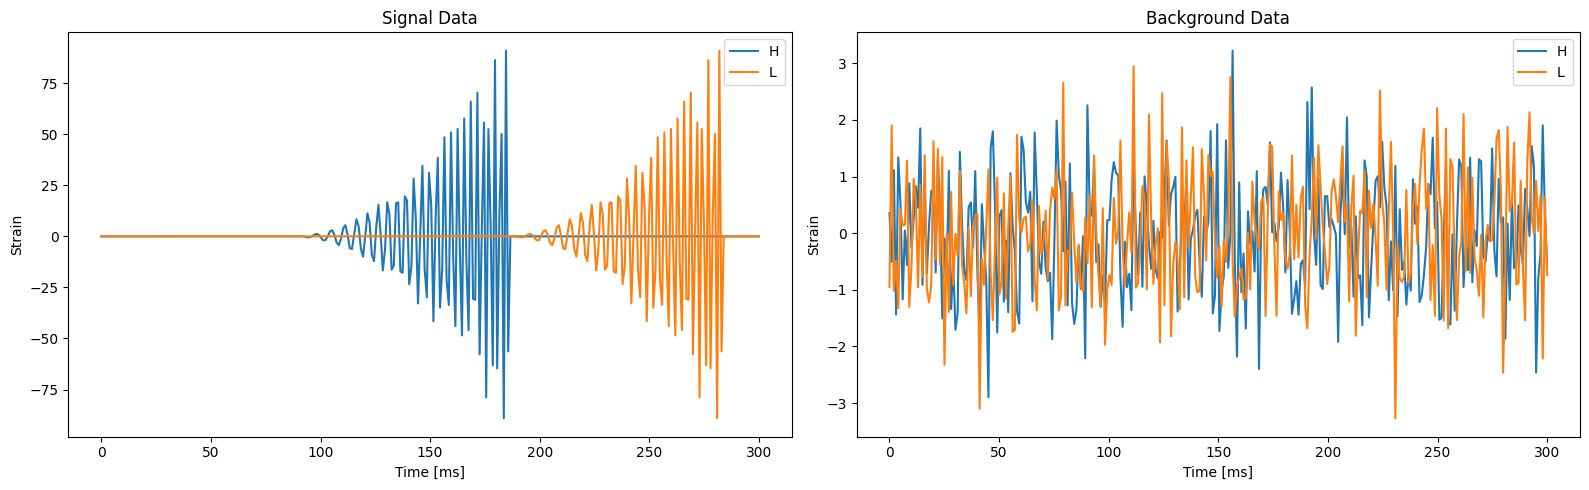

In [130]:
USE_NEW_GENERATOR = True  # set False to use the legacy toy generator below

if USE_NEW_GENERATOR:
    notebooks_dir = project_root / "notebooks"
    if str(notebooks_dir) not in sys.path:
        sys.path.insert(0, str(notebooks_dir))
    import data_generation as gw_data

    def gen_sig(amplitude=100.0):
        sig_h = gw_data.generate_gw_signal(1, n_timesteps=300, amplitude=amplitude)[0]
        sig_l = gw_data.generate_gw_signal(1, n_timesteps=300, amplitude=amplitude)[0]
        t = np.linspace(0, 300, num=300)
        return np.stack([t, sig_h, sig_l], axis=1)

    def gen_bg():
        noise_h = gw_data.generate_noise(1, n_timesteps=300)[0]
        noise_l = gw_data.generate_noise(1, n_timesteps=300)[0]
        t = np.linspace(0, 300, num=300)
        return np.stack([t, noise_h, noise_l], axis=1)

else:
    def gen_sig(amplitude=100.0):
        """Generate toy signal data mimicking gravitational wave detection.
        
        Parameters
        ----------
        amplitude : float, default=100.0
            Signal amplitude scaling factor
        
        Returns
        -------
        numpy.ndarray
            Generated signal data with gravitational wave-like characteristics
        """
        T = 20.0 # ms
        delta = 5. # ms
        A = amplitude
        return gen_data(A,T,delta,0)

    def gen_bg():
        """Generate toy background data for gravitational wave analysis.
        
        Returns
        -------
        numpy.ndarray
            Generated background data without signal components
        """
        T = 20.0 # ms
        delta = 5. # ms
        A = 0.0
        return gen_data(A,T,delta,0.25)

    def gen_data(A, T, delta, noise):
        """Generate simulated gravitational wave detector data.
        
        Creates toy data mimicking gravitational wave signals in dual detectors
        with configurable amplitude, period, time delay, and noise levels.
        
        Parameters
        ----------
        A : float
            Signal amplitude
        T : float
            Signal period in milliseconds
        delta : float
            Time delay between detectors in milliseconds
        noise : float
            Gaussian noise standard deviation
            
        Returns
        -------
        numpy.ndarray, shape (100, 5)
            Generated data with columns [time, H_detector, L_detector, H+L, H-L]
            
        Notes
        -----
        This is a toy model for testing R-Anode methodology on simple
        time-series data before applying to particle physics datasets.
        """
        data = []
        for t in np.linspace(0,300,num=300): #ms
            h = A * np.sin(2*np.pi*t / T) * scipy.stats.norm.pdf(t,loc=150,scale=20) + np.random.normal(scale=noise)
            l = A * np.sin(2*np.pi*(t+delta) / T)* scipy.stats.norm.pdf(t+delta,loc=150,scale=20) + np.random.normal(scale=noise)
            data.append( [ t,h,l])

        return np.array(data)

sdata = gen_sig()
bdata = gen_bg()

# Plot signal and background data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Signal data
ax1.plot(sdata[:,0],sdata[:,1],label="H")
ax1.plot(sdata[:,0],sdata[:,2],label="L")
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Strain")
ax1.set_title("Signal Data")
ax1.legend()

# Background data
ax2.plot(bdata[:,0],bdata[:,1],label="H")
ax2.plot(bdata[:,0],bdata[:,2],label="L")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Strain")
ax2.set_title("Background Data")
ax2.legend()

plt.tight_layout()
plt.show()


Verified: signal is added sample-wise to the background
Background shape: (300, 3)
Signal template shape: (300, 3)
Signal+background combined shape: (300, 3)
Columns: [time, H, L, H+L, H-L, label]


[]

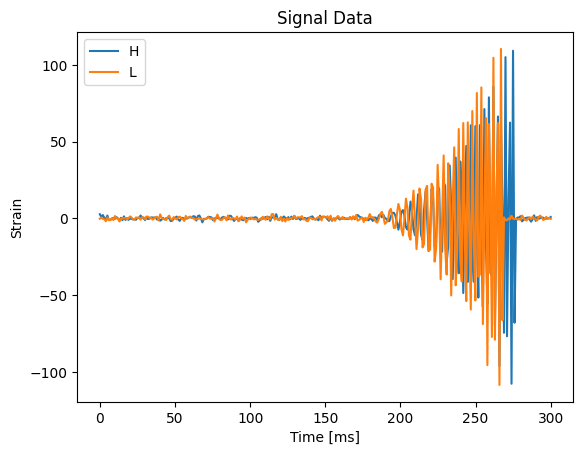

In [131]:
SIGNAL_AMPLITUDE = 120.0  # tweak amplitude to study sensitivity

raw_bkg = gen_bg()
raw_sig = gen_sig(amplitude=SIGNAL_AMPLITUDE)

def combine_signal_with_background(background: np.ndarray, signal: np.ndarray, scale: float = 1.0) -> np.ndarray:
    if background.shape != signal.shape:
        raise ValueError("Signal and background must share identical shape")
    combined = background.copy()
    if not np.allclose(background[:, 0], signal[:, 0], atol=1e-8):
        raise ValueError("Time grids for signal and background do not align")
    combined[:, 1] = background[:, 1] + scale * signal[:, 1]
    combined[:, 2] = background[:, 2] + scale * signal[:, 2]
    return combined

combined_signal_raw = combine_signal_with_background(raw_bkg, raw_sig)
assert np.allclose(combined_signal_raw[:, 0], raw_bkg[:, 0])
assert np.allclose(combined_signal_raw[:, 1] - raw_bkg[:, 1], raw_sig[:, 1])
assert np.allclose(combined_signal_raw[:, 2] - raw_bkg[:, 2], raw_sig[:, 2])
print("Verified: signal is added sample-wise to the background")

print(f"Background shape: {raw_bkg.shape}")
print(f"Signal template shape: {raw_sig.shape}")
print(f"Signal+background combined shape: {combined_signal_raw.shape}")
print("Columns: [time, H, L, H+L, H-L, label]")

plt.clf()
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,1],label="H")
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,2],label="L")
plt.ylabel("Strain")
plt.title("Signal Data")
plt.xlabel("Time [ms]")
plt.legend()
plt.plot()


In [132]:
# You must already have these defined somewhere:
# def gen_bg(): ...
# def gen_sig(amplitude: float): ...

# -------- Dataset windows (background + injected signals) --------
num_backgrounds = 10000
num_signals = 10

time = np.linspace(0, 300, num=300)[:, None]  # (300,1)

bg_windows = [gen_bg() for _ in range(num_backgrounds)]       # each: (300,3) [time, H, L]
bg_windows = np.stack(bg_windows, axis=0)                     # (N_bg,300,3)

SIGNAL_AMPLITUDE = 120
sig_windows = [
    combine_signal_with_background(gen_bg(), gen_sig(amplitude=SIGNAL_AMPLITUDE))
    for _ in range(num_signals)
]

all_windows = np.concatenate([bg_windows, np.stack(sig_windows, axis=0)], axis=0)
labels = np.array([0] * num_backgrounds + [1] * num_signals, dtype=int)

perm = np.random.default_rng(2025).permutation(len(labels))
all_windows = all_windows[perm]
labels = labels[perm]

train_h = all_windows[:, :, 1].astype(np.float32)             # (N,300)
train_l = all_windows[:, :, 2].astype(np.float32)             # (N,300)

print("Dataset:", train_h.shape, train_l.shape)
print("Num backgrounds:", num_backgrounds, "Num signals:", num_signals)


Dataset: (10010, 300) (10010, 300)
Num backgrounds: 10000 Num signals: 10


## Generate Flow

In [133]:
# Standardization from the full dataset (single-signal contamination is negligible)
mean_h = train_h.mean()
std_h  = train_h.std() + 1e-8
mean_l = train_l.mean()
std_l  = train_l.std() + 1e-8

def standardize(h, l):
    h_n = (h - mean_h) / std_h
    l_n = (l - mean_l) / std_l
    return h_n.astype(np.float32), l_n.astype(np.float32)

train_hn, train_ln = standardize(train_h, train_l)

# Build time conditioning in [0,1]
train_t = np.arange(train_hn.shape[0], dtype=np.float32)
train_t = (train_t - train_t.min()) / (train_t.max() - train_t.min() + 1e-8)


In [134]:
class FlowDataset(Dataset):
    def __init__(self, h_windows, l_windows, t_cond):
        assert h_windows.shape == l_windows.shape
        self.h = torch.as_tensor(h_windows, dtype=torch.float32)  # (N,300)
        self.l = torch.as_tensor(l_windows, dtype=torch.float32)  # (N,300)
        self.t = torch.as_tensor(t_cond, dtype=torch.float32)     # (N,)

    def __len__(self):
        return self.h.shape[0]

    def __getitem__(self, idx):
        x = torch.cat([self.h[idx], self.l[idx]], dim=0)          # (600,)
        c = self.t[idx].view(1)                                   # (1,)
        return x, c

flow_train_ds = FlowDataset(train_hn, train_ln, train_t)
flow_train_loader = DataLoader(flow_train_ds, batch_size=256, shuffle=True)

In [135]:
def build_conditional_rqs_flow(
    dim=600,
    context_dim=1,
    num_layers=6,
    hidden_features=256,
    num_bins=8,
    tail_bound=3.0
):
    transforms = []
    for _ in range(num_layers):
        transforms.append(
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=dim,
                hidden_features=hidden_features,
                context_features=context_dim,
                num_bins=num_bins,
                tails="linear",
                tail_bound=tail_bound,
                activation=nn.ReLU(),
                dropout_probability=0.0,
                use_residual_blocks=True
            )
        )
        # Permute between layers so different dimensions get modeled in different order
        transforms.append(ReversePermutation(features=dim))

    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[dim])
    return Flow(transform, base_dist)

flow = build_conditional_rqs_flow(
    dim=600,
    context_dim=1,
    num_layers=6,
    hidden_features=256,
    num_bins=8,
    tail_bound=3.0
).to(torch.float32).to(device)

flow

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=600, out_features=256, bias=True)
          (context_layer): Linear(in_features=1, out_features=256, bias=True)
          (activation): ReLU()
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (context_layer): Linear(in_features=1, out_features=256, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=256, out_features=256, bias=True)
              )
              (activation): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=256, out_features=13800, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
     

Epoch 1/10 | NLL: 1088.673383
Epoch 2/10 | NLL: 971.815981
Epoch 3/10 | NLL: 939.249503
Epoch 4/10 | NLL: 918.831973
Epoch 5/10 | NLL: 905.003974
Epoch 6/10 | NLL: 894.305251
Epoch 7/10 | NLL: 886.086947
Epoch 8/10 | NLL: 879.234560
Epoch 9/10 | NLL: 873.375029
Epoch 10/10 | NLL: 868.450240


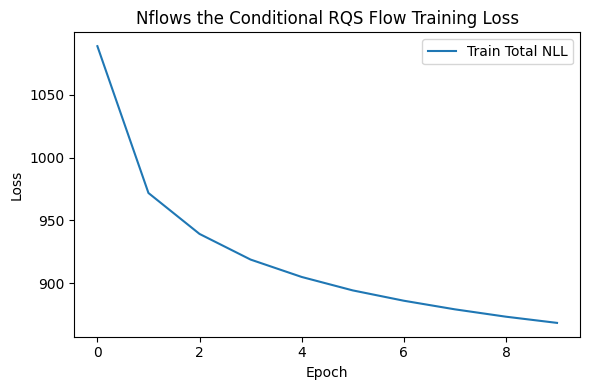

In [136]:
def train_nflows(flow, loader, epochs=10, lr=1e-4):
    flow.train()
    opt = optim.Adam(flow.parameters(), lr=lr)
    train_losses = []

    for ep in range(epochs):
        total_nll = 0.0
        count = 0

        for x, c in loader:
            x = x.to(device)  # (B,600)
            c = c.to(device)  # (B,1)

            opt.zero_grad()
            logp = flow.log_prob(inputs=x, context=c)  # (B,)
            nll = -logp.mean()
            nll.backward()
            opt.step()

            total_nll += nll.item() * x.size(0)
            count += x.size(0)
        train_losses.append(total_nll / count)

        print(f"Epoch {ep+1}/{epochs} | NLL: {total_nll/count:.6f}")

    return flow, train_losses

flow, train_losses = train_nflows(flow, flow_train_loader, epochs=10, lr=1e-4)

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Total NLL")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Nflows the Conditional RQS Flow Training Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [137]:
# def generate_flow_estimates(flow, t_cond, batch_size=512):
#     flow.eval()
#     N = len(t_cond)
#     X_hat = torch.zeros((N, 600), dtype=torch.float32)

#     with torch.no_grad():
#         for i in range(0, N, batch_size):
#             cb = torch.as_tensor(t_cond[i:i+batch_size], dtype=torch.float32).view(-1, 1).to(device)
#             # nflows Flow.sample(num_samples, context=...)
#             xb = flow.sample(num_samples=cb.size(0), context=cb).cpu()  # (B,600)
#             X_hat[i:i+batch_size] = xb

#     return X_hat.view(N, 2, 300)  # (N,2,300)

def generate_flow_estimates(flow, t_cond, batch_size=256):
    """
    Generates exactly ONE sample per context row.
    Returns X_hat: (N,2,300) torch.float32 on CPU.
    """
    flow.eval()
    N = len(t_cond)
    X_hat = torch.zeros((N, 600), dtype=torch.float32)

    with torch.no_grad():
        for i in tqdm(range(0, N, batch_size)):
            cb = torch.as_tensor(t_cond[i:i+batch_size], dtype=torch.float32).view(-1, 1).to(device)
            
            # IMPORTANT: one sample per context row
            xb = flow.sample(num_samples=1, context=cb)   # shape typically (B, 1, 600)
            xb = xb.squeeze(1).cpu()                      # -> (B, 600)

            X_hat[i:i+batch_size] = xb

    return X_hat.view(N, 2, 300)


# Real training windows tensor (N,2,300)
X_real_train = torch.stack(
    [torch.as_tensor(train_hn, dtype=torch.float32),
     torch.as_tensor(train_ln, dtype=torch.float32)],
    dim=1
)  # (N,2,300)

X_hat_train = generate_flow_estimates(flow, train_t)
X_real_train.shape, X_hat_train.shape

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [27:39<00:00, 41.50s/it]


(torch.Size([10010, 2, 300]), torch.Size([10010, 2, 300]))

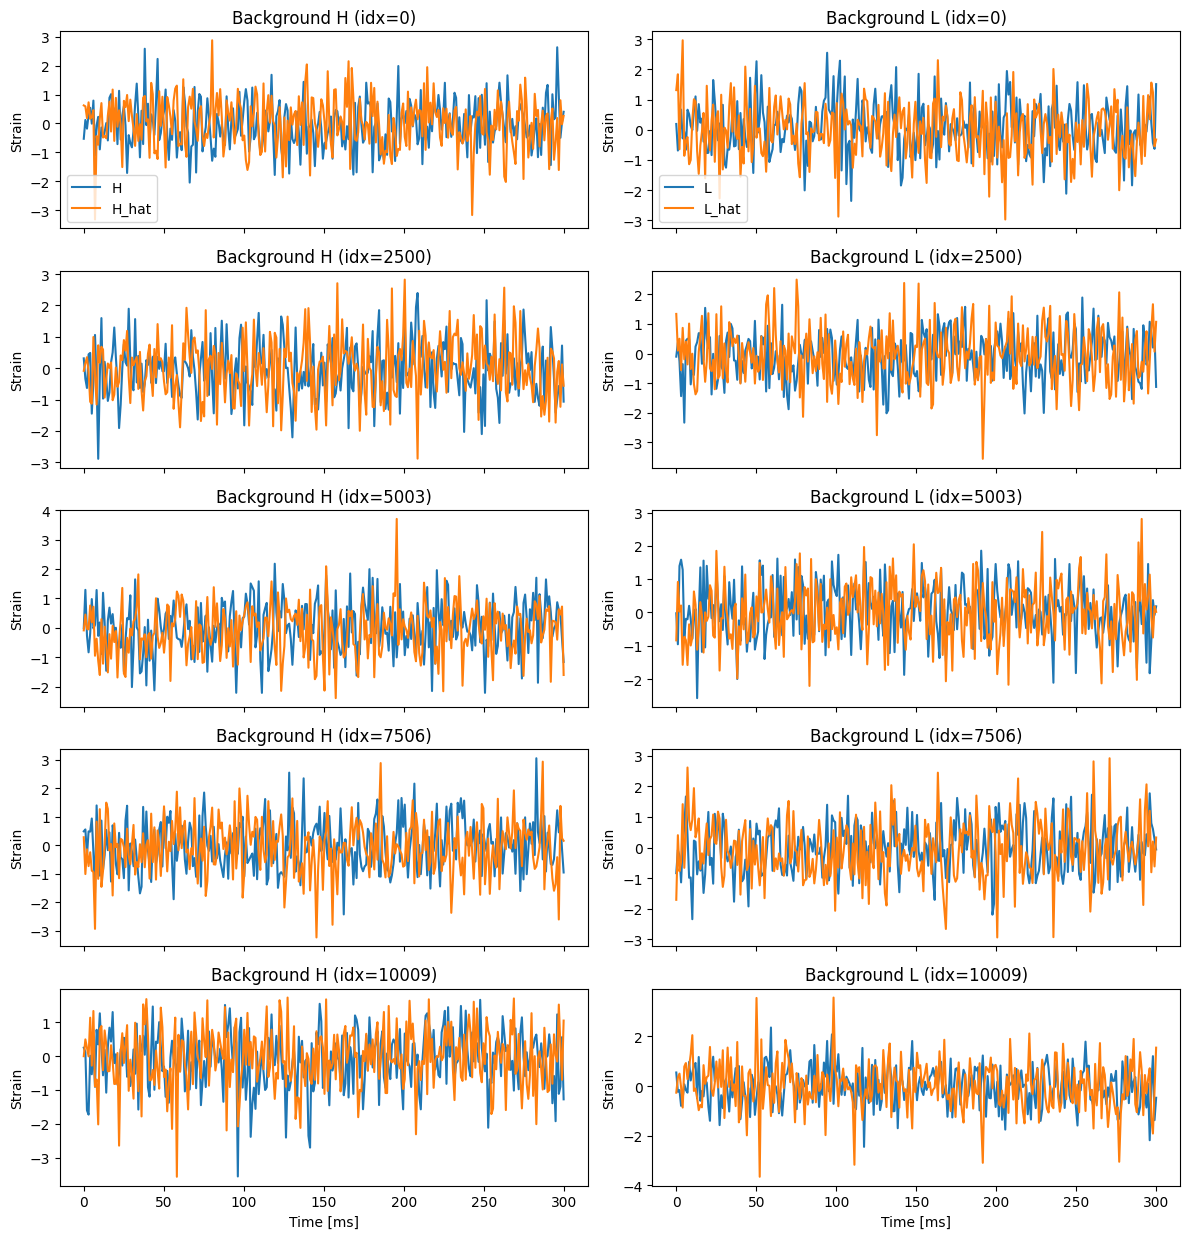

In [154]:
# Plot multiple background examples
num_examples = 5
bg_indices = np.where(labels == 0)[0]
if len(bg_indices) == 0:
    raise ValueError("No background samples available for plotting")

if len(bg_indices) >= num_examples:
    bg_indices = np.linspace(0, len(bg_indices) - 1, num_examples, dtype=int)
    bg_indices = bg_indices
    bg_indices = np.take(np.where(labels == 0)[0], bg_indices)
else:
    bg_indices = bg_indices

fig, axes = plt.subplots(len(bg_indices), 2, figsize=(12, 2.5 * len(bg_indices)), sharex=True)

if len(bg_indices) == 1:
    axes = np.array([axes])

for row, idx in enumerate(bg_indices):
    ax_h = axes[row, 0]
    ax_l = axes[row, 1]

    ax_h.plot(time, X_real_train[idx, 0, :], label="H")
    ax_h.plot(time, X_hat_train[idx, 0, :], label="H_hat")
    ax_h.set_ylabel("Strain")
    ax_h.set_title(f"Background H (idx={idx})")
    if row == 0:
        ax_h.legend()

    ax_l.plot(time, X_real_train[idx, 1, :], label="L")
    ax_l.plot(time, X_hat_train[idx, 1, :], label="L_hat")
    ax_l.set_ylabel("Strain")
    ax_l.set_title(f"Background L (idx={idx})")
    if row == 0:
        ax_l.legend()

for ax in axes[-1, :]:
    ax.set_xlabel("Time [ms]")

plt.tight_layout()
plt.show()


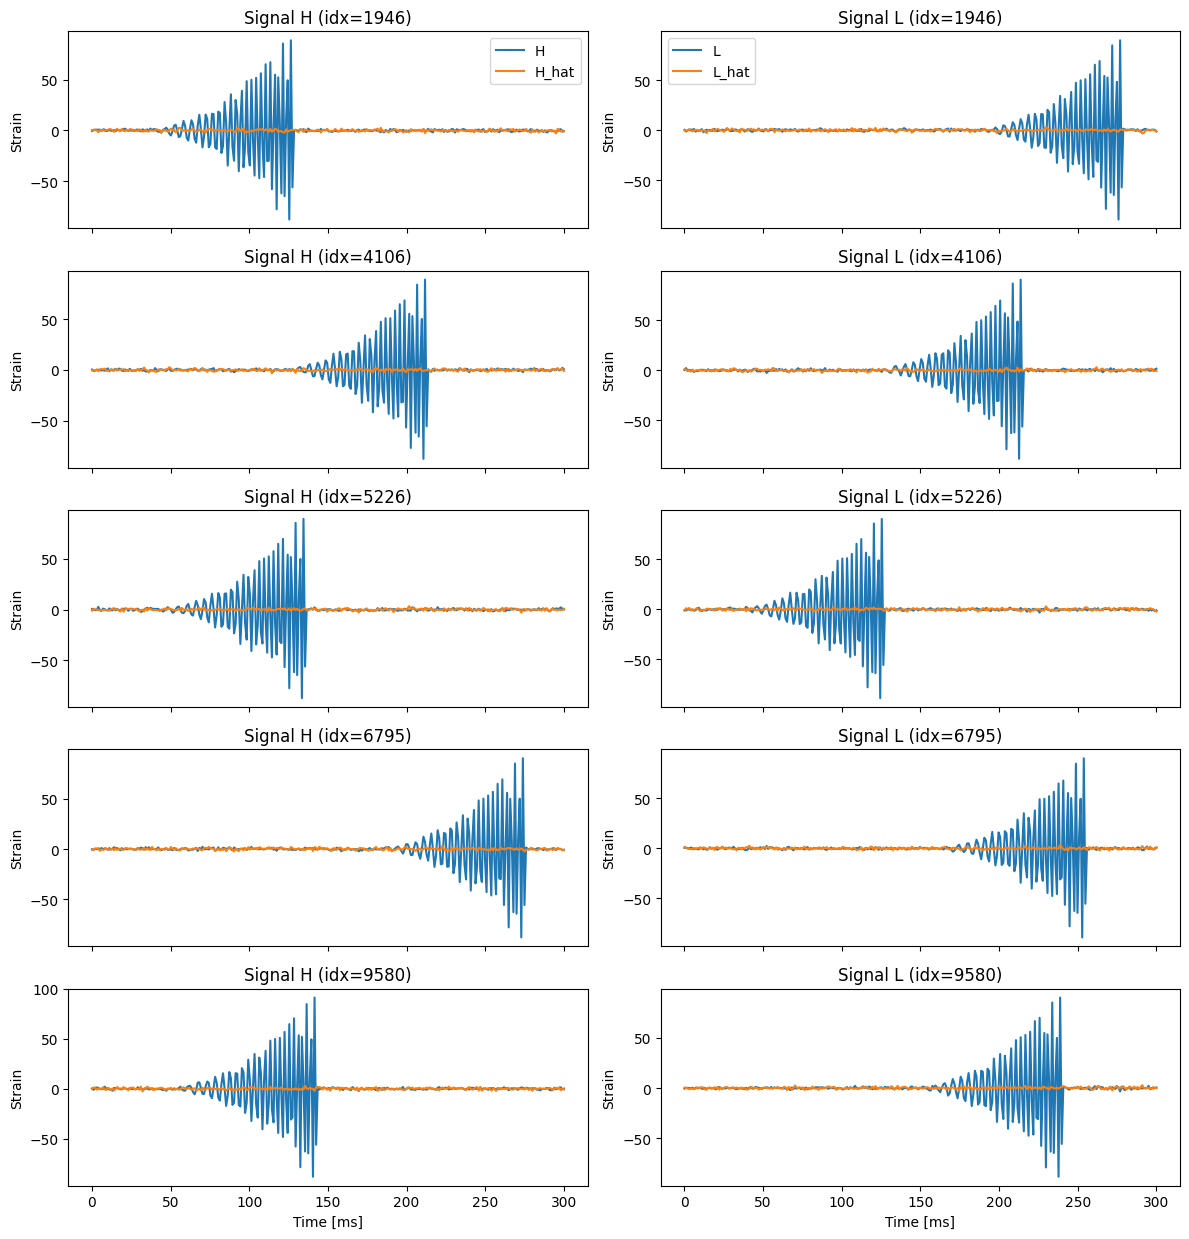

In [155]:
# Plot signal examples vs flow reconstruction
num_examples = 5
sig_indices = np.where(labels == 1)[0]
if len(sig_indices) == 0:
    raise ValueError("No signal samples available for plotting")

if len(sig_indices) >= num_examples:
    sig_indices = np.linspace(0, len(sig_indices) - 1, num_examples, dtype=int)
    sig_indices = np.take(np.where(labels == 1)[0], sig_indices)
else:
    sig_indices = sig_indices

fig, axes = plt.subplots(len(sig_indices), 2, figsize=(12, 2.5 * len(sig_indices)), sharex=True)

if len(sig_indices) == 1:
    axes = np.array([axes])

for row, idx in enumerate(sig_indices):
    ax_h = axes[row, 0]
    ax_l = axes[row, 1]

    ax_h.plot(time, X_real_train[idx, 0, :], label="H")
    ax_h.plot(time, X_hat_train[idx, 0, :], label="H_hat")
    ax_h.set_ylabel("Strain")
    ax_h.set_title(f"Signal H (idx={idx})")
    if row == 0:
        ax_h.legend()

    ax_l.plot(time, X_real_train[idx, 1, :], label="L")
    ax_l.plot(time, X_hat_train[idx, 1, :], label="L_hat")
    ax_l.set_ylabel("Strain")
    ax_l.set_title(f"Signal L (idx={idx})")
    if row == 0:
        ax_l.legend()

for ax in axes[-1, :]:
    ax.set_xlabel("Time [ms]")

plt.tight_layout()
plt.show()


In [140]:
USE_EXTERNAL_CLASSIFIER = True  # set True to use notebooks/model.py

if USE_EXTERNAL_CLASSIFIER:
    notebooks_dir = project_root / "notebooks"
    if str(notebooks_dir) not in sys.path:
        sys.path.insert(0, str(notebooks_dir))
    import model as gw_model

    class ExternalGWClassifier(nn.Module):
        def __init__(self, input_length=600):
            super().__init__()
            self.base = gw_model.create_model(input_length=input_length)
            self.use_time = False

        def forward(self, x, t=None):
            # x: (B,2,300) -> (B,1,600)
            x = torch.cat([x[:, 0, :], x[:, 1, :]], dim=1).unsqueeze(1)
            prob = self.base(x)
            prob = prob.clamp(1e-6, 1 - 1e-6)
            return torch.logit(prob)

else:
    class CNNClassifierWithTime(nn.Module):
        def __init__(self, use_time=False):
            super().__init__()
            self.use_time = use_time

            self.feature_net = nn.Sequential(
                nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                nn.ReLU(inplace=True),
                nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
                nn.ReLU(inplace=True),
                nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool1d(1),
            )
            in_dim = 64 + (1 if use_time else 0)
            self.head = nn.Linear(in_dim, 1)

        def forward(self, x, t=None):
            h = self.feature_net(x).squeeze(-1)
            if self.use_time:
                if t is None:
                    raise ValueError("use_time=True but t was None")
                t = t.view(-1, 1)
                h = torch.cat([h, t], dim=1)
            return self.head(h).squeeze(-1)

class RealVsEstimatedDatasetWithTime(Dataset):
    def __init__(self, X_real, X_est, t_cond):
        N = X_real.size(0)
        self.X = torch.cat([X_real, X_est], dim=0)  # (2N,2,300)
        self.y = torch.cat([torch.ones(N), torch.zeros(N)], dim=0)

        t = torch.as_tensor(t_cond, dtype=torch.float32)
        self.t = torch.cat([t, t], dim=0)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.t[idx]


Epoch 1/50 | BCE: 0.523480
Epoch 2/50 | BCE: 0.250162
Epoch 3/50 | BCE: 0.208450
Epoch 4/50 | BCE: 0.211938
Epoch 5/50 | BCE: 0.187507
Epoch 6/50 | BCE: 0.206435
Epoch 7/50 | BCE: 0.194688
Epoch 8/50 | BCE: 0.186738
Epoch 9/50 | BCE: 0.176620
Epoch 10/50 | BCE: 0.180707
Epoch 11/50 | BCE: 0.182581
Epoch 12/50 | BCE: 0.178492
Epoch 13/50 | BCE: 0.159664
Epoch 14/50 | BCE: 0.156716
Epoch 15/50 | BCE: 0.161026
Epoch 16/50 | BCE: 0.151654
Epoch 17/50 | BCE: 0.157040
Epoch 18/50 | BCE: 0.154421
Epoch 19/50 | BCE: 0.142113
Epoch 20/50 | BCE: 0.142628
Epoch 21/50 | BCE: 0.138452
Epoch 22/50 | BCE: 0.137232
Epoch 23/50 | BCE: 0.132073
Epoch 24/50 | BCE: 0.124440
Epoch 25/50 | BCE: 0.127512
Epoch 26/50 | BCE: 0.117234
Epoch 27/50 | BCE: 0.151230
Epoch 28/50 | BCE: 0.116964
Epoch 29/50 | BCE: 0.112152
Epoch 30/50 | BCE: 0.108941
Epoch 31/50 | BCE: 0.105724
Epoch 32/50 | BCE: 0.111092
Epoch 33/50 | BCE: 0.099200
Epoch 34/50 | BCE: 0.098400
Epoch 35/50 | BCE: 0.105276
Epoch 36/50 | BCE: 0.088648
E

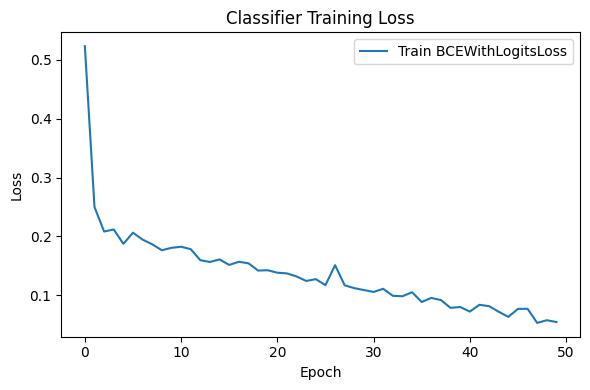

In [141]:
def train_classifier(model, loader, epochs=50, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    train_losses = []

    for ep in range(epochs):
        model.train()
        total = 0.0
        count = 0

        for xb, yb, tb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            tb = tb.to(device)

            opt.zero_grad()
            logits = model(xb, tb if model.use_time else None)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

            total += loss.item() * xb.size(0)
            count += xb.size(0)
        train_losses.append(total / count)

        print(f"Epoch {ep+1}/{epochs} | BCE: {total/count:.6f}")

    return model, train_losses

use_time_for_classifier = True
if USE_EXTERNAL_CLASSIFIER:
    use_time_for_classifier = False
    clf = ExternalGWClassifier()
else:
    clf = CNNClassifierWithTime(use_time=use_time_for_classifier)

clf_ds = RealVsEstimatedDatasetWithTime(X_real_train, X_hat_train, train_t)
clf_loader = DataLoader(clf_ds, batch_size=256, shuffle=True)

clf, train_losses = train_classifier(clf, clf_loader, epochs=50, lr=1e-3)

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train BCEWithLogitsLoss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classifier Training Loss")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/50 | BCE: 0.679301
Epoch 2/50 | BCE: 0.554086
Epoch 3/50 | BCE: 0.425746
Epoch 4/50 | BCE: 0.392470
Epoch 5/50 | BCE: 0.346475
Epoch 6/50 | BCE: 0.329624
Epoch 7/50 | BCE: 0.298782
Epoch 8/50 | BCE: 0.272681
Epoch 9/50 | BCE: 0.243070
Epoch 10/50 | BCE: 0.221936
Epoch 11/50 | BCE: 0.213909
Epoch 12/50 | BCE: 0.207502
Epoch 13/50 | BCE: 0.205843
Epoch 14/50 | BCE: 0.205284
Epoch 15/50 | BCE: 0.195467
Epoch 16/50 | BCE: 0.196426
Epoch 17/50 | BCE: 0.192409
Epoch 18/50 | BCE: 0.193020
Epoch 19/50 | BCE: 0.205649
Epoch 20/50 | BCE: 0.209307
Epoch 21/50 | BCE: 0.186864
Epoch 22/50 | BCE: 0.188680
Epoch 23/50 | BCE: 0.189187
Epoch 24/50 | BCE: 0.188604
Epoch 25/50 | BCE: 0.189480
Epoch 26/50 | BCE: 0.189136
Epoch 27/50 | BCE: 0.186934
Epoch 28/50 | BCE: 0.183755
Epoch 29/50 | BCE: 0.186320
Epoch 30/50 | BCE: 0.183827
Epoch 31/50 | BCE: 0.190075
Epoch 32/50 | BCE: 0.188663
Epoch 33/50 | BCE: 0.183763
Epoch 34/50 | BCE: 0.190603
Epoch 35/50 | BCE: 0.187040
Epoch 36/50 | BCE: 0.186720
E

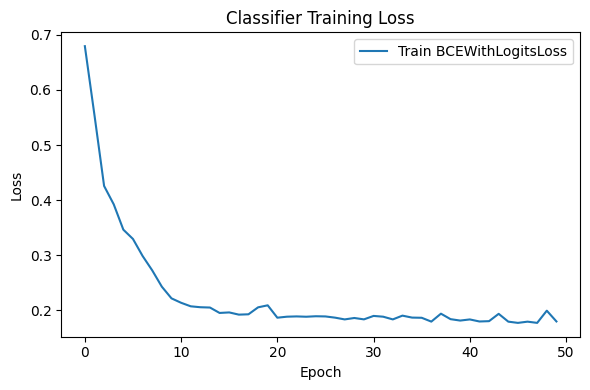

In [142]:
def train_classifier(model, loader, epochs=50, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    train_losses = []

    for ep in range(epochs):
        model.train()
        total = 0.0
        count = 0

        for xb, yb, tb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            tb = tb.to(device)

            opt.zero_grad()
            logits = model(xb, tb if model.use_time else None)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

            total += loss.item() * xb.size(0)
            count += xb.size(0)
        train_losses.append(total / count)

        print(f"Epoch {ep+1}/{epochs} | BCE: {total/count:.6f}")

    return model, train_losses

use_time_for_classifier = True
clf_ds = RealVsEstimatedDatasetWithTime(X_real_train, X_hat_train, train_t)
clf_loader = DataLoader(clf_ds, batch_size=256, shuffle=True)

clf = CNNClassifierWithTime(use_time=use_time_for_classifier)
clf, train_losses = train_classifier(clf, clf_loader, epochs=50, lr=1e-3)

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train BCEWithLogitsLoss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classifier Training Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [149]:
def anomaly_scores_classifier(model, h_windows, l_windows, t_cond, batch_size=512):
    X = torch.stack([torch.as_tensor(h_windows, dtype=torch.float32),
                     torch.as_tensor(l_windows, dtype=torch.float32)], dim=1)  # (N,2,300)

    t = torch.as_tensor(t_cond, dtype=torch.float32)

    model.eval()
    scores = []
    with torch.no_grad():
        for i in range(0, X.size(0), batch_size):
            xb = X[i:i+batch_size].to(device)
            tb = t[i:i+batch_size].to(device)
            logits = model(xb, tb if model.use_time else None)
            scores.append(torch.sigmoid(logits).cpu())
    return torch.cat(scores, dim=0)

scores_eval = anomaly_scores_classifier(clf, train_hn, train_ln, train_t)

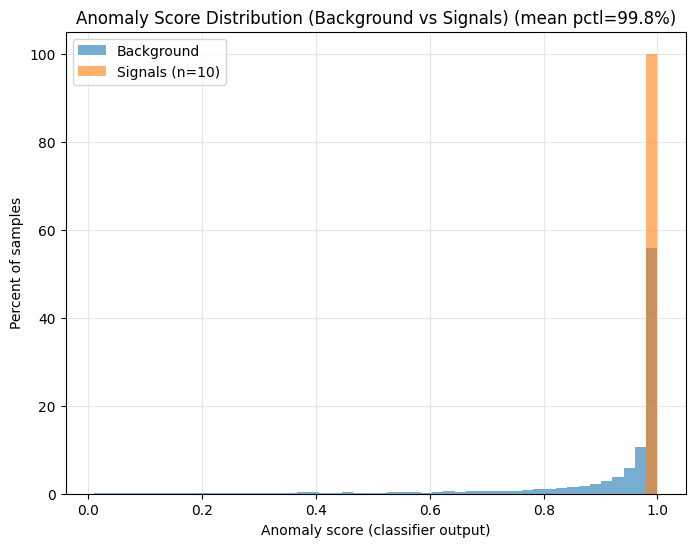

Signal percentile mean: 99.75%
Signal percentile min/max: 99.03% / 100.00%


In [167]:
scores_np = scores_eval.detach().cpu().numpy() if hasattr(scores_eval, "detach") else np.asarray(scores_eval)

bg_scores = scores_np[labels == 0]
sig_scores = scores_np[labels == 1]

bins = 50
# Optional x-axis window: set to (xmin, xmax) or leave as None
xlim_window = None

if xlim_window is not None:
    xmin, xmax = xlim_window
    bin_edges = np.linspace(xmin, xmax, bins + 1)
else:
    all_scores = np.concatenate([bg_scores, sig_scores]) if len(sig_scores) else bg_scores
    bin_edges = np.histogram_bin_edges(all_scores, bins=bins)

bg_weights = np.ones_like(bg_scores) * (100.0 / len(bg_scores)) if len(bg_scores) else None
sig_weights = np.ones_like(sig_scores) * (100.0 / len(sig_scores)) if len(sig_scores) else None

sig_percentiles = [(bg_scores < s).mean() * 100 for s in sig_scores]
mean_pct = float(np.mean(sig_percentiles)) if len(sig_scores) else float("nan")

plt.figure(figsize=(8, 6))
plt.hist(bg_scores, bins=bin_edges, weights=bg_weights, alpha=0.6, label="Background")
if len(sig_scores):
    plt.hist(sig_scores, bins=bin_edges, weights=sig_weights, alpha=0.6, label=f"Signals (n={len(sig_scores)})")
if xlim_window is not None:
    plt.xlim(*xlim_window)
plt.xlabel("Anomaly score (classifier output)")
plt.ylabel("Percent of samples")
plt.title(f"Anomaly Score Distribution (Background vs Signals) (mean pctl={mean_pct:.1f}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

if len(sig_scores):
    print(f"Signal percentile mean: {mean_pct:.2f}%")
    print(f"Signal percentile min/max: {min(sig_percentiles):.2f}% / {max(sig_percentiles):.2f}%")


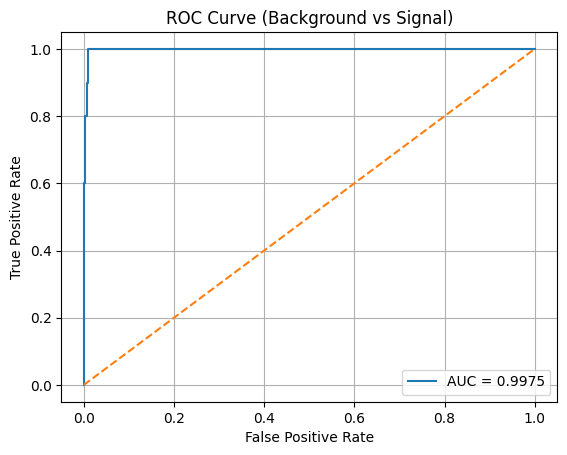

In [168]:
# Convert scores to a NumPy array
scores = scores_eval.detach().cpu().numpy() if hasattr(scores_eval, "detach") else np.asarray(scores_eval)

# ROC points + AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
auc = roc_auc_score(labels, scores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Background vs Signal)")
plt.legend()
plt.grid(True)
plt.show()